In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from scipy.stats import norm

In [2]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

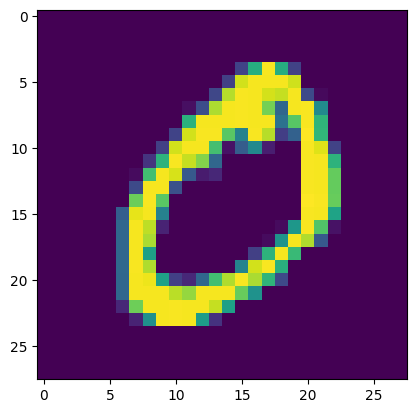

In [3]:
# visualizing data
plt.imshow(X_train[1]);

In [4]:
# normalize image
# grayscale range is from 0 (black) to 255 (white)
print(f'X_train before normalization \n\n{X_train[0][10]}')
X_train, X_test = X_train.astype('float32')/255, X_test.astype('float32')/255
print(f'\n\nX_train after normalization \n\n{X_train[0][10]}')

X_train before normalization 

[  0   0   0   0   0   0   0   0   0  14   1 154 253  90   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


X_train after normalization 

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.05490196 0.00392157 0.6039216
 0.99215686 0.3529412  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [5]:
# flatten the image 28x28 = 784
print(f'X_train before flattening: {X_train.shape}')
X_train_flat, X_test_flat = X_train.reshape(X_train.shape[0], -1), X_test.reshape(X_test.shape[0], -1)
print(f'X_train after flattening: {X_train_flat.shape}')

X_train before flattening: (60000, 28, 28)
X_train after flattening: (60000, 784)


In [6]:
#setting up model parameters
batch_size, num_epochs = 200, 150
#hidden state and latent state dimentionality
n_hidden, z_dim = 256, 2

In [7]:
# VAE sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

In [8]:
# Encoder - from 784->256->128->2
inputs_flat = Input(shape=(X_train_flat.shape[1],))
x_flat = Dense(n_hidden, activation='relu')(inputs_flat)  # first hidden layer
x_flat = Dense(n_hidden // 2, activation='relu')(x_flat)  # second hidden layer

# Hidden state, which we will pass into the Model to get the Encoder.
mu_flat = Dense(z_dim)(x_flat)
log_var_flat = Dense(z_dim)(x_flat)
z_flat = Lambda(sampling, output_shape=(z_dim,))([mu_flat, log_var_flat])


In [9]:
# Decoder - from 2->128->256->784
latent_inputs = Input(shape=(z_dim,))
z_decoder1 = Dense(n_hidden // 2, activation='relu')(latent_inputs)
z_decoder2 = Dense(n_hidden, activation='relu')(z_decoder1)
y_decoder = Dense(X_train_flat.shape[1], activation='sigmoid')(z_decoder2)
decoder_flat = Model(latent_inputs, y_decoder, name="decoder")

outputs_flat = decoder_flat(z_flat)


In [10]:
# Custom layer to calculate the VAE loss
class VAELossLayer(Model):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        inputs_flat, outputs_flat, mu_flat, log_var_flat = inputs
        reconstruction_loss = losses.binary_crossentropy(inputs_flat, outputs_flat) * X_train_flat.shape[1]
        kl_loss = 0.5 * K.sum(K.square(mu_flat) + K.exp(log_var_flat) - log_var_flat - 1, axis=-1)
        total_loss = K.mean(reconstruction_loss + kl_loss)
        self.add_loss(total_loss)
        return outputs_flat

# Instantiate and compile the VAE model
vae_loss_layer = VAELossLayer()([inputs_flat, outputs_flat, mu_flat, log_var_flat])

# Build the VAE model
vae_flat = Model(inputs_flat, vae_loss_layer)
vae_flat.compile(optimizer='adam')

vae_flat.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    200,960 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        258 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        258 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 2)         │          0 │ dense_2[0][0],    │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 784)       │    234,896 │ lambda[0][0]      │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer      │ (None, 784)       │          0 │ input_layer[0][0… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ dense_2[0][0],    │
│                     │                   │            │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 469,268 (1.79 MB)

 Trainable params: 469,268 (1.79 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Assuming you stored the history of training
history = vae_flat.fit(
    X_train_flat,
    shuffle=True,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_test_flat, None),
    verbose=1
)

Epoch 1/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 256.1184 - val_loss: 182.0132
Epoch 2/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 175.4923 - val_loss: 165.5921
Epoch 3/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 164.0950 - val_loss: 160.4298
Epoch 4/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 159.5448 - val_loss: 157.6314
Epoch 5/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 157.1168 - val_loss: 155.6466
Epoch 6/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 155.0287 - val_loss: 153.6011
Epoch 7/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 153.5330 - val_loss: 152.3137
Epoch 8/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 152.1469 - val_loss: 150.9565
Epoch 9/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 150.6277 - val_loss: 149.5208
Epoch 10/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 149.5370 - val_loss: 148.7921
Epoch 11/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 148.2821 - val_loss: 147.65

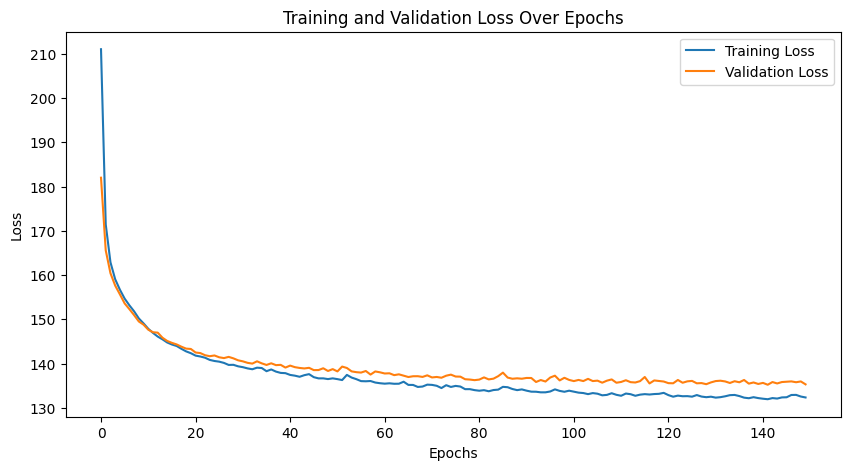

In [12]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

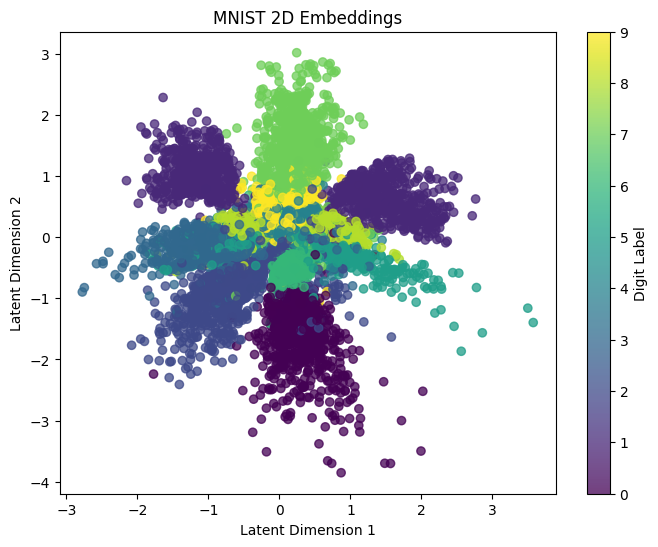

In [15]:
# Visualizing embeddings

# Build the encoder model
encoder_f = Model(inputs_flat, z_flat)  # flat encoder

# Get the latent space representation for the test data
X_test_latent = encoder_f.predict(X_test_flat, batch_size=batch_size, verbose=0)

# Plot the digit classes in the latent space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_test_latent[:, 0], X_test_latent[:, 1], c=y_test, alpha=0.75, cmap='viridis')
plt.title('MNIST 2D Embeddings')
plt.colorbar(scatter, label='Digit Label')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

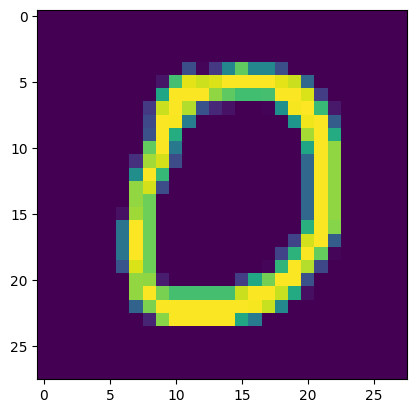

In [22]:
plt.imshow(X_test_flat[10].reshape(28,28));

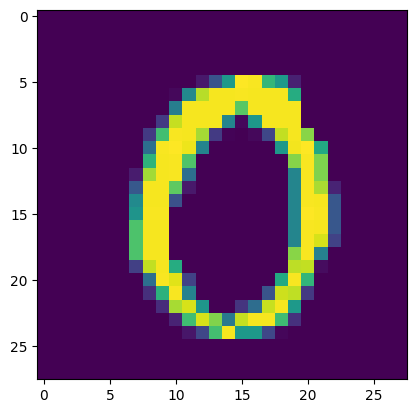

In [21]:
plt.imshow(X_test_flat[13].reshape(28,28));

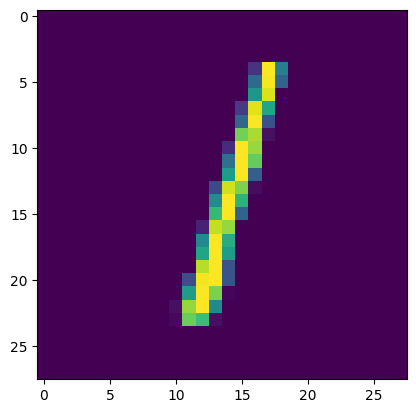

In [20]:
plt.imshow(X_test_flat[2].reshape(28,28));

In [23]:
# calculate vectors for each digit
zero_A = X_test_latent[10]
zero_B = X_test_latent[13]
one = X_test_latent[2]

print(f"Embedding for the first ZERO is  {zero_A}")
print(f"Embedding for the second ZERO is {zero_B}")
print(f"Embedding for the ONE is         {one}")

Embedding for the first ZERO is  [ 0.14174765 -1.3797213 ]
Embedding for the second ZERO is [ 0.1393677 -1.141627 ]
Embedding for the ONE is         [1.5204487 1.1922411]


# Sentence Embedding of Textual Data

In [27]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

c:\Users\behna\Desktop\venv\dev_env\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\behna\.cache\huggingface\hub\models--sentence-transformers--paraphrase-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [34]:
#Sentences we want to encode. Example:
sentence = ['The team enjoyed the hike through the meadow',
            'The national park had great views',
            'Olive oil drizzled over pizza tastes delicious']

#Sentences are encoded by calling model.encode()
embedding = model.encode(sentence)

print(f'SHAPE:{embedding.shape}')
print('\n')
#Preview the embeddings
print(f'VECTORS:\n{embedding}')

SHAPE:(3, 384)


VECTORS:
[[ 0.3706196   0.26414254  0.21265706 ...  0.14994544 -0.25794926
  -0.23970778]
 [ 0.669333    0.40094972 -0.4820838  ...  0.10645859 -1.5067165
  -0.01547366]
 [-0.26555917  0.11172301 -0.14733018 ...  0.42197528  0.8839462
   0.10763886]]


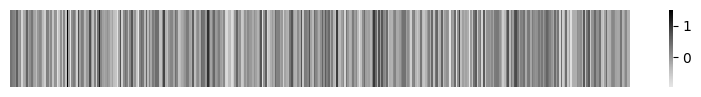

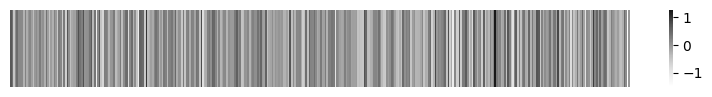

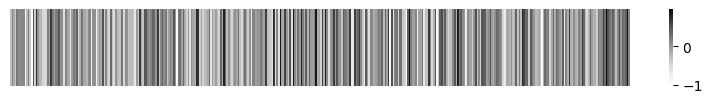

In [37]:
sns.heatmap(embedding[0].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[1].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[2].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

## Measuring the distance between these Image and Sentence Embeddings

### Euclidean Distance(L2)
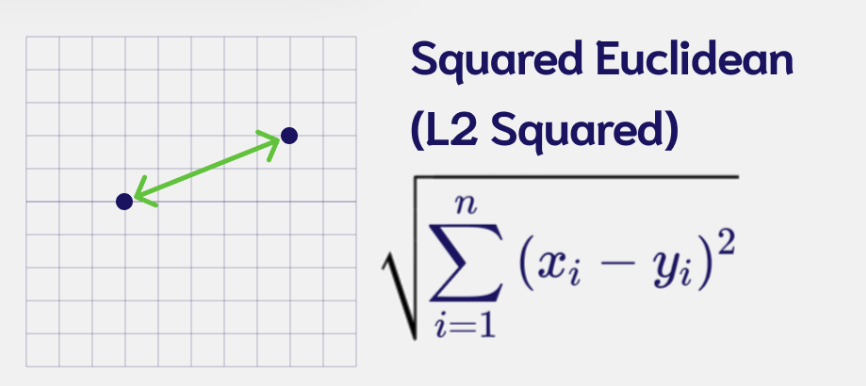

In [38]:
# Euclidean Distance
L2 = [(zero_A[i] - zero_B[i])**2 for i in range(len(zero_A))]
L2 = np.sqrt(np.array(L2).sum())
print(L2)

0.23810622436105225


In [39]:
#An alternative way of doing this
np.linalg.norm((zero_A - zero_B), ord=2)

0.23810622

In [40]:
#Calculate L2 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=2))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=2))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=2))

Distance zeroA-zeroB: 0.23810622
Distance zeroA-one:   2.9181855
Distance zeroB-one:   2.7118857


### Manhattan Distance(L1)
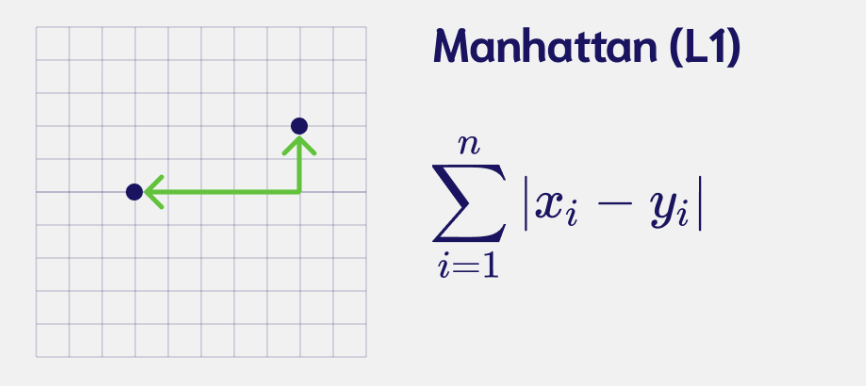

In [41]:
L1 = [zero_A[i] - zero_B[i] for i in range(len(zero_A))]
L1 = np.abs(L1).sum()

print(L1)

0.24047428


In [42]:
#an alternative way of doing this is
np.linalg.norm((zero_A - zero_B), ord=1)

0.24047428

In [43]:
#Calculate L1 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=1))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=1))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=1))

Distance zeroA-zeroB: 0.24047428
Distance zeroA-one:   3.9506633
Distance zeroB-one:   3.7149491


### Dot Product
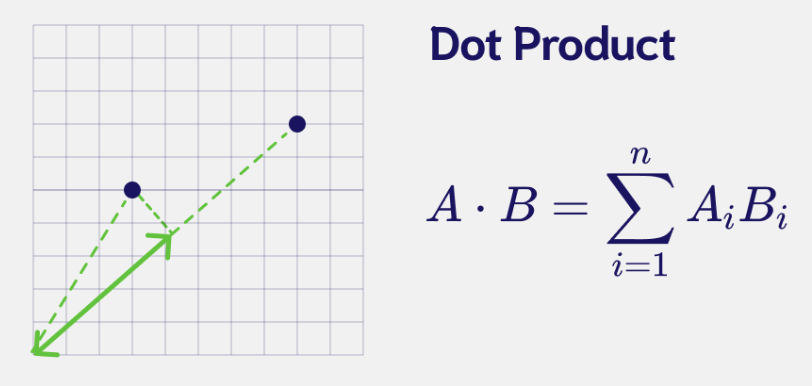

In [44]:
# Dot Product
np.dot(zero_A,zero_B)

1.594882

In [45]:
#Calculate Dot products
print("Distance zeroA-zeroB:", np.dot(zero_A, zero_B))
print("Distance zeroA-one:  ", np.dot(zero_A, one))
print("Distance zeroB-one:  ", np.dot(zero_B, one))

Distance zeroA-zeroB: 1.594882
Distance zeroA-one:   -1.4294404
Distance zeroB-one:   -1.1491932


### Cosine Distance
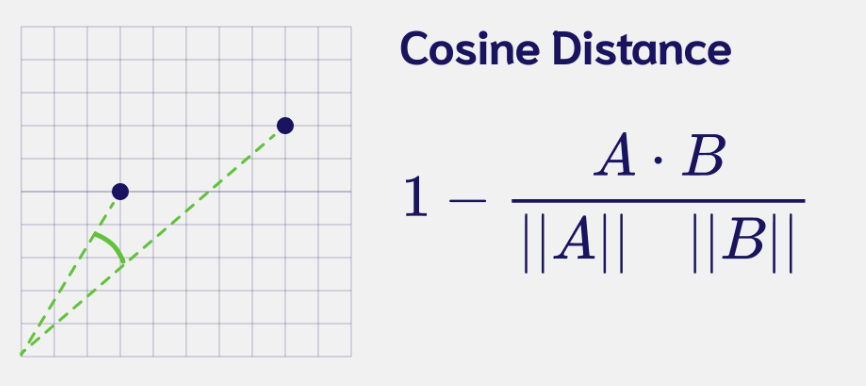

In [46]:
# Cosine Distance
cosine = 1 - np.dot(zero_A,zero_B)/(np.linalg.norm(zero_A)*np.linalg.norm(zero_B))
print(f"{cosine:.6f}")

0.000182


In [47]:
zero_A/zero_B

array([1.0170768, 1.208557 ], dtype=float32)

In [48]:
# Cosine Distance function
def cosine_distance(vec1,vec2):
  cosine = 1 - (np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))
  return cosine

In [49]:
#Cosine Distance
print(f"Distance zeroA-zeroB: {cosine_distance(zero_A, zero_B): .6f}")
print(f"Distance zeroA-one:   {cosine_distance(zero_A, one): .6f}")
print(f"Distance zeroB-one:   {cosine_distance(zero_B, one): .6f}")

Distance zeroA-zeroB:  0.000182
Distance zeroA-one:    1.533401
Distance zeroB-one:    1.517149


## Calculating embeddings for the sentences

In [50]:
#Dot Product
print("Distance 0-1:", np.dot(embedding[0], embedding[1]))
print("Distance 0-2:", np.dot(embedding[0], embedding[2]))
print("Distance 1-2:", np.dot(embedding[1], embedding[2]))

Distance 0-1: 26.497885
Distance 0-2: 2.078576
Distance 1-2: 4.019214


In [51]:
#Cosine Distance
print("Distance 0-1: ", cosine_distance(embedding[0], embedding[1]))
print("Distance 0-2: ", cosine_distance(embedding[0], embedding[2]))
print("Distance 1-2: ", cosine_distance(embedding[1], embedding[2]))

Distance 0-1:  0.535033643245697
Distance 0-2:  0.9639393426477909
Distance 1-2:  0.9288790449500084
